In [2]:
pip install --user fitsio

  Using cached fitsio-1.2.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached fitsio-1.2.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (825 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import os
os.environ["NCCL_DEBUG"] = "INFO"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import pickle
import time
import gc
import sys
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from utility_functions import extract_data_from_fits
from utility_functions import train_CNN_js
from MLmodels import *
from sklearn.model_selection import train_test_split
import datetime
import pytz
from concurrent.futures import ThreadPoolExecutor

np.random.seed(100)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# For saving the progress to txt file
zurich_timezone = pytz.timezone('Europe/Zurich')

start_global = time.time()

2025-05-22 09:39:58.762701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-22 09:39:58.762737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-22 09:39:58.806602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 09:40:03.728887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  4
GPU Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [2]:
data_path = os.path.expandvars('$SCRATCH/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/')
results_path = os.path.expandvars('$SCRATCH/RESULTS/modifiedMainQSO_minsignal2_amplified5/A/')
os.makedirs(results_path, exist_ok=True)

flux_list = []
labels_list = []

fits_files = [os.path.join(data_path, file) for file in os.listdir(data_path)[:10] if file.endswith('.fits')]

for fits_file in fits_files:
    flux, labels, _ = extract_data_from_fits(fits_file)
    flux_list.append(flux)
    labels_list.append(labels)

# Concatenate all flux and labels arrays
all_flux = np.concatenate(flux_list, axis=0)
all_labels = np.concatenate(labels_list, axis=0)
print(len(all_labels))

x_train, x_testvalid, y_train, y_testvalid = train_test_split(all_flux, all_labels, train_size=0.7, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_testvalid, y_testvalid, test_size=0.5, random_state=42)

# Standardize and then normalize each spectrum individually
x_train = np.array([(x - np.mean(x)) / np.std(x) for x in x_train])
x_valid = np.array([(x - np.mean(x)) / np.std(x) for x in x_valid])
x_test = np.array([(x - np.mean(x)) / np.std(x) for x in x_test])

# Normalize each standardized spectrum (min-max normalization to [-1, 1])
x_train = np.array([x / np.max(np.abs(x)) for x in x_train])
x_valid = np.array([x / np.max(np.abs(x)) for x in x_valid])
x_test = np.array([x / np.max(np.abs(x)) for x in x_test])

# Expand Dimensions to Channels
x_train = np.expand_dims(x_train, axis=-1)
x_valid = np.expand_dims(x_valid, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test  = y_test.astype('float32')

del all_flux, all_labels
gc.collect()

Processing file: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/modified_minsignal2_desi_bright_qso_batch42.fits
Processing file: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/modified_minsignal2_desi_bright_qso_batch39.fits
Processing file: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/modified_minsignal2_desi_bright_qso_batch3.fits
Processing file: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/modified_minsignal2_desi_bright_qso_batch9.fits
Processing file: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/modified_minsignal2_desi_bright_qso_batch48.fits
Processing file: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplified5/A/modified_minsignal2_desi_bright_qso_batch6.fits
Processing file: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2_amplifie

0

In [3]:
model = CNN_model3
# batch_size, epochs, learning_rate, momentum, kernelsize, maxpooling, (nfilters)
# bounds = [[16, 256], [10, 50]] #0
# bounds = [[16, 64], [100, 200], [0.0001, 0.01], [0.1, 0.9], [2, 8], [2, 3]] #1
# bounds = [[32, 128], [30, 80], [0.001, 0.01], [0.1, 0.9], [2, 8], [2, 3], [4, 64]] #2
bounds = [[32, 128], [10, 100], [0.001, 0.01], [0.1, 0.9], [2, 8], [4, 128], [0.1, 0.8]] #3
#bounds = [[32, 128], [30, 80], [0.001, 0.01], [0.1, 0.9], [2, 8], [4, 64], [1e-6, 1e-1]] #4

print("Starting")
res_opt_method, CM_opt, hyperparam_optim, optim_results = train_CNN_js(model, bounds, x_train, y_train, x_valid, y_valid, x_test, y_test, strategy)
print("Completed")


# =============================================================================
# # SAVE RESULTS
# =============================================================================

# use a dictionary with keys using the right names.
results = {'results': res_opt_method, 'confusion matrix': CM_opt, 'hyperparameters': hyperparam_optim,
           'y_test': list(y_test)}
a_file = open(results_path + "results3.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

# export optimization results
a_file = open(results_path + "GA_results3.pkl", "wb")
pickle.dump(optim_results, a_file)
a_file.close()

## OUT
end_global = time.time()
print(f"FINISHED, Runtime: {(end_global - start_global) / 60:.2f} minutes")
print(f"{hyperparam_optim=}")

Starting
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7777, 64)          384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2592, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2588, 32)          10272     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1294, 32)          0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 41408)             0         
                                                                 
 dropout (Dropout)           (None, 41408)     

I0000 00:00:1747932165.815912  734117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


970/970 [==============================] - 20s 9ms/step - loss: 0.3403 - auc: 0.1055 - f1_score: 0.0050 - val_loss: 0.3277 - val_auc: 0.1038 - val_f1_score: 0.0000e+00
Epoch 2/62
970/970 [==============================] - 7s 7ms/step - loss: 0.3326 - auc: 0.1112 - f1_score: 0.0000e+00 - val_loss: 0.3576 - val_auc: 0.1092 - val_f1_score: 0.0000e+00
Epoch 3/62
970/970 [==============================] - 7s 7ms/step - loss: 1.0506 - auc: 0.1293 - f1_score: 0.0331 - val_loss: 0.3222 - val_auc: 0.1070 - val_f1_score: 0.0016
Epoch 4/62
970/970 [==============================] - 7s 7ms/step - loss: 0.3137 - auc: 0.1688 - f1_score: 0.0077 - val_loss: 0.3263 - val_auc: 0.1079 - val_f1_score: 0.0016
Epoch 5/62
970/970 [==============================] - 7s 7ms/step - loss: 0.3151 - auc: 0.1754 - f1_score: 0.0225 - val_loss: 0.3310 - val_auc: 0.1105 - val_f1_score: 0.0015
Epoch 6/62
970/970 [==============================] - 7s 7ms/step - loss: 0.8200 - auc: 0.1666 - f1_score: 0.0639 - val_loss: 0.

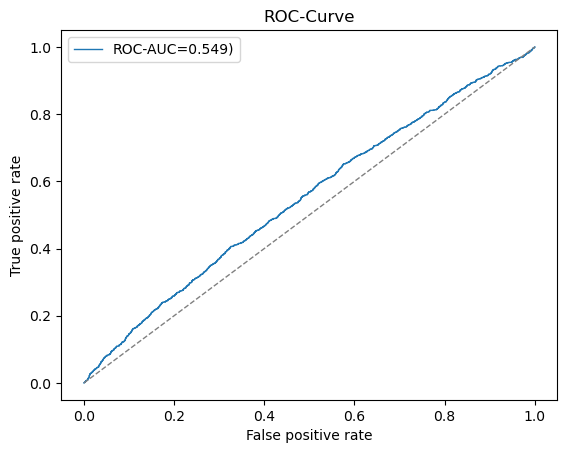

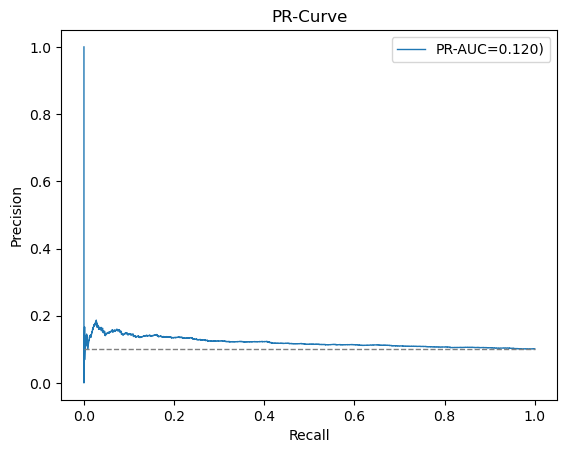

In [4]:
from utility_functions import FDRthreshold_js, ROC_PR
import matplotlib.pyplot as plt

# =============================================================================
# # =============================================================================
# # ROC & PR curves
# # =============================================================================
# =============================================================================

y_test = np.array(results['y_test'])
y_pred_prob = np.array(results['results']['Y_pred_prob'])

ls_roc_auc, ls_fpr, ls_tpr, ls_pr_auc, ls_precision, ls_recall, pr_no_skill, ls_roc_auc_noskill, ls_fpr_noskill, ls_tpr_noskill = ROC_PR(y_pred_prob, y_test)

#ROC
plt.figure()
#plt.plot(ls_fpr, ls_tpr, lw=1, color=color_ls[met], label=met+" (AUC={})".format(np.round(ls_roc_auc[met],3)))
plt.plot(ls_fpr, ls_tpr, lw=1, label=f"ROC-AUC={ls_roc_auc:.3f})")
plt.plot(ls_fpr_noskill, ls_tpr_noskill, linestyle='--', lw=1, color='gray')  #'No Skill'
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC-Curve')
plt.legend()
# plt.savefig(visualisation_path + 'ROC_' + planet + '_alpha' + str(alpha) + '_bal' + str(bal) + '_combined_CV_' + str(plotname) + '_version' + str(version) + 'frame' + str(frame) + '_fold' + str(j) + '_js.pdf')
plt.show()


#PR
plt.figure()
#plt.plot(ls_recall, ls_precision[met], lw=1, color=color_ls[met], label=met + " (AUC={})".format(np.round(ls_pr_auc[met],3)))
plt.plot(ls_recall, ls_precision, lw=1, label=f"PR-AUC={ls_pr_auc:.3f})")
plt.plot([0, 1], [pr_no_skill, pr_no_skill], linestyle='--', lw=1, color='gray')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR-Curve')
plt.legend()
#plt.savefig(visualisation_path + 'PR_' + planet + '_alpha' + str(alpha) + '_bal' + str(bal) + '_combined_CV_' + str(plotname) + '_version' + str(version) + 'frame' + str(frame) + '_fold' + str(j) + '_js.pdf')
plt.show()


In [5]:
hyperparam_optim

[54.5,
 33.125,
 0.006203125,
 0.45625000000000004,
 4.90625,
 63.765625,
 0.4144531250000001]